# Plot onset channel sgrams with clinical onsets

In [2]:
import numpy as np
import numpy.matlib
import pandas as pd
import os
import scipy.io as sio
import ieeg_funcs as ief
import re
import dgFuncs as dg

from sklearn import preprocessing
import sys
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [7]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

<module 'dgFuncs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/dgFuncs.py'>

In [25]:
szr_mat = sio.loadmat('/Users/davidgroppe/ONGOING/EU_EEG/FR_1096/109600102_0000.mat')
szr_mat.keys()

dict_keys(['use_chans', 'stop_ts', 'just_ieeg_fname', '__version__', 'is_szr', '__header__', 'start_ts', 'tpts_sec', '__globals__', 'Fs', 'ieeg256', 'szr_type'])

In [32]:
print(szr_mat['use_chans'].shape)
bro=str(szr_mat['use_chans'][0,0][0])
print(type(bro))

(8, 1)
<class 'str'>


In [16]:
# Define sub and count number of szr files
# Directory where data are
path_dict=ief.get_path_dict()
eu_root_dir=path_dict['eu_root']

sub='1096'
sub_dir=os.path.join(eu_root_dir,'FR_'+sub)
print('Reading mat fnames from %s' % sub_dir)
mat_fnames=list()
for fname in os.listdir(sub_dir):
    if fname.endswith('.mat'):
        mat_fnames.append(fname)

n_szrs=len(mat_fnames)
print('%d szr files for sub %s' % (n_szrs,sub))

Reading mat fnames from /Users/davidgroppe/ONGOING/EU_EEG/FR_1096
1 szr files for sub 1096


In [79]:
n_chan=len(szr_mat['use_chans'][0,:])
print('%d channels' % n_chan)
chan_labels=list()
for chan_ct in range(n_chan):
    chan_labels.append(szr_mat['use_chans'][0,chan_ct][0])    

Fs=szr_mat['Fs'][0][0]
tpts_sec=szr_mat['tpts_sec'][0,:]
n_tpt=len(tpts_sec)

# convert data to avg ref
ieeg256=szr_mat['ieeg256']
mn_ieeg256=np.mean(ieeg256,axis=0)
ieeg256=ieeg256-np.matlib.repmat(mn_ieeg256, n_chan, 1)

69 channels


In [4]:
pd.rolling_mean?

In [19]:
bro_df.rolling?

In [23]:
bro=np.arange(0,10)
bro_df=pd.DataFrame(bro)
print(bro)
#pd.rolling_mean(x, N)[N-1:]
n=5
sis=dg.running_mean(bro,n)
unc=sis[0::2]
print(sis)
print(unc)
print(len(bro))
print(len(bro)-n+1)
print(len(sis))
dud=pd.rolling_mean(bro,n,n)
print(dud)

[0 1 2 3 4 5 6 7 8 9]
[ 2.  3.  4.  5.  6.  7.]
[ 2.  4.  6.]
10
6
6
[ nan  nan  nan  nan   2.   3.   4.   5.   6.   7.]


/Users/davidgroppe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


In [102]:
n_tpt=len(tpts_sec)
print(n_tpt)

921600


In [90]:
wind_len=int(Fs)
wind_step=int(wind_len/2)
n_tapers=3
chan_sgram, freqs, sgram_sec=ief.mt_sgram(ieeg256[0,:Fs*100], Fs, wind_len, wind_step, n_tapers, tpts_sec)
n_freqs=len(freqs)
trim_mn=np.zeros((n_chan,n_freqs))
trim_sd=np.zeros((n_chan,n_freqs))
for f_ct, f in enumerate(freqs):
    trim_mn[0,f_ct], trim_sd[0,f_ct]=dg.trimmed_mn_sd(chan_sgram[f_ct,:],0.4)
    chan_sgram[f_ct,:]=(chan_sgram[f_ct,:]-trim_mn[0,f_ct])/trim_sd[0,f_ct]

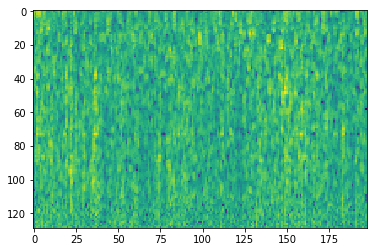

In [91]:
plt.figure(1)
plt.clf()
plt.imshow(chan_sgram)

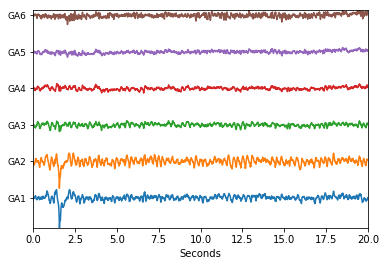

In [71]:
plt.figure(1)
plt.clf()
#strat_plot(dat,chan_labels,fig_id=1,show_chan_ids=None,h_offset=2,srate=1,tpts_sec=None,fontsize=9):
ief.strat_plot(ieeg256[:,(onset_id-Fs*10):(onset_id+Fs*10)],chan_labels,fig_id=1,
               show_chan_ids=np.arange(int(n_chan/10)),h_offset=700,srate=Fs);

In [104]:
# Compute sgram normalization factors for each channel

# Spectrogram parameters
wind_len=int(Fs)
wind_step=int(wind_len/2)
n_tapers=3
n_freqs=False

# TODO: use all mat_fnames
#for szr_ct, szr_fname in enumerate(mat_fnames):
for szr_ct, szr_fname in enumerate(mat_fnames[:1]):
    # Load Szr
    szr_mat=sio.loadmat(os.path.join(sub_dir,szr_fname))
    szr_type=szr_mat['szr_type'][0]
    print('File %s, szr type is %s' % (szr_fname,szr_type))

    # Find onset
    Fs=szr_mat['Fs'][0][0]
#     onset_id=np.argmax(szr_mat['is_szr']>0)
#     print(onset_id)
    szr_ids=np.argwhere(szr_mat['is_szr'][:,0]>0)
    onset_id=szr_ids[0]
    offset_id=szr_ids[-1]
    print('%f sec of preonset data' % ((onset_id-1)/Fs))
    
    # Loop over chans
    for chan_ct in range(n_chan):
        if np.mod(chan_ct,5)==0:
            print('Working on channel %d/%d' % (chan_ct+1,n_chan))
        # compute pre-szr spectrogram baseline TODO change FS*100 below
        chan_sgram, freqs, sgram_sec=ief.mt_sgram(ieeg256[chan_ct,:Fs*600], Fs, wind_len, 
                                                  wind_step, n_tapers, tpts_sec)
        if n_freqs==False:
            n_freqs=len(freqs)
            trim_mn=np.zeros((n_chan,n_freqs))
            trim_sd=np.zeros((n_chan,n_freqs))
        for f_ct, f in enumerate(freqs):
            trim_mn[chan_ct,f_ct], trim_sd[chan_ct,f_ct]=dg.trimmed_mn_sd(chan_sgram[f_ct,:],0.4)

print('Done!')

File 109600102_0001.mat, szr type is Subclinical
527.996094 sec of preonset data
Working on channel 1/69
Working on channel 6/69
Working on channel 11/69
Working on channel 16/69
Working on channel 21/69
Working on channel 26/69
Working on channel 31/69
Working on channel 36/69
Working on channel 41/69
Working on channel 46/69
Working on channel 51/69
Working on channel 56/69
Working on channel 61/69
Working on channel 66/69
Done!


In [119]:
# Compute normalized sgrams for 30 sec before onset and until offset

# TODO: use all mat_fnames
#for szr_ct, szr_fname in enumerate(mat_fnames):
for szr_ct, szr_fname in enumerate(mat_fnames[:1]):
    start_id=np.max([0, onset_id-Fs*30]) #0 or 30 seconds before onset, whichever is bigger
    stop_id=np.min([n_tpt, offset_id+Fs*30]) #szr offset or 30 seconds before onset, whichever is bigger
    #stop_id=offset_id #this should always be within file limits
    
    # Loop over chans
    for chan_ct in range(n_chan):
        if np.mod(chan_ct,5)==0:
            print('Working on channel %d/%d' % (chan_ct+1,n_chan))
        # compute pre-szr spectrogram baseline TODO change FS*100 below
        chan_sgram, freqs, sgram_sec=ief.mt_sgram(ieeg256[chan_ct,:Fs*600], Fs, wind_len, 
                                                  wind_step, n_tapers, tpts_sec)
        if chan_ct==0:
            n_freqs=len(freqs)
            trim_mn=np.zeros((n_chan,n_freqs))
            trim_sd=np.zeros((n_chan,n_freqs))
            start_sgram_id=dg.find_nearest(sgram_sec,tpts_sec[onset_id])
            stop_sgram_id=dg.find_nearest(sgram_sec,tpts_sec[offset_id])
            n_wind=stop_sgram_id-start_sgram_id
            all_chan_sgram=np.zeros((n_chan,n_freqs,n_wind))
        all_chan_sgram[chan_ct,:,:]=chan_sgram[:,start_sgram_id:stop_sgram_id]
        # TODO NORMALIZE!!!
        #for f_ct, f in enumerate(freqs):
        #    trim_mn[chan_ct,f_ct], trim_sd[chan_ct,f_ct]=dg.trimmed_mn_sd(chan_sgram[f_ct,:],0.4)
print('Done!')

Working on channel 1/69
Working on channel 6/69
Working on channel 11/69
Working on channel 16/69
Working on channel 21/69
Working on channel 26/69
Working on channel 31/69
Working on channel 36/69
Working on channel 41/69
Working on channel 46/69
Working on channel 51/69
Working on channel 56/69
Working on channel 61/69
Working on channel 66/69
Done!


In [112]:
print(all_chan_sgram.shape)
print(n_freqs)
print(n_chan)
print(n_wind)


(69, 129, 76)
129
69
76


In [114]:
all_chan_sgram=np.reshape(all_chan_sgram,(n_freqs*n_chan,n_wind))


In [118]:
all_chan_sgram.shape

(8901, 76)

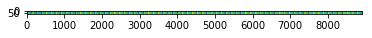

In [117]:
plt.figure(2)
plt.clf()
plt.imshow(all_chan_sgram.T)

(array([134918]), array([145146]))

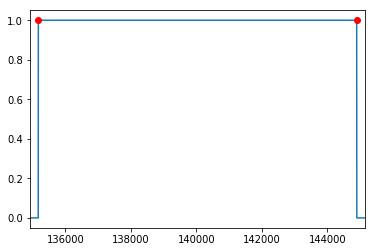

In [101]:
plt.figure(1)
plt.clf()
plt.plot(szr_mat['is_szr'])
# plt.plot(onset_id,1,'ro')
plt.plot(szr_ids[0],1,'ro')
plt.plot(szr_ids[-1],1,'ro')
plt.xlim([szr_ids[0]-250, szr_ids[-1]+250])
# plt.xlim([onset_id-250, onset_id+250])

In [12]:
print(szr_mat['szr_type'][0])

Subclinical


In [ ]:
# Load manual onset times
csv_path='/Users/davidgroppe/ONGOING/SZR_SPREAD/PATIENTS/'+sub+'/ONSETTIMES/'
print('Importing manual onset times from %s' % csv_path)
csv_list=list()
for f in os.listdir(csv_path):
    if f.endswith('manualOnsets.txt'):
        csv_list.append(f)

n_files=len(csv_list)
print('%d manual wide-band onset files found' % n_files)

In [ ]:
# Import Clinician Szr Onset Times
if sys.platform=='linux':
    onset_csv_dir='/home/dgroppe/TWH_INFO/CLINICIAN_ONSET_TIMES'
else:
    onset_csv_dir='/Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES'
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

In [ ]:
# Get list of channels and ID of onset channel
chan_labels=ief.import_chan_labels(sub)
onset_chan_id=chan_labels.index(onset_chan)

In [ ]:
imp.reload(ief) 
n_chan=len(chan_labels)

# Loop through manual files (since I have one for each mat file)
#for man_file_loop in range(n_files): TODO use this!!!
for man_file_loop in range(1):
    szr_name=csv_list[man_file_loop].split('_manualOnsets')[0]
    #     digit_substrings=re.findall(r'\d+',csv_list[man_file_loop])
    #     szr_day=int(digit_substrings[0])
    #     szr_num=int(digit_substrings[1])

    # See if I have a clinician onset
    print(szr_name)
    # ?? onset_tpt=ief.clin_onset_tpt(szr_name, onset_df)
    onset_tpt, onset_chan=ief.clin_onset_tpt_and_chan(szr_name, onset_df)
    
    if onset_tpt<0:
        print('Warning: %s has a clinician onset time that is earlier than the file start time.' % szr_name)
        print('Ignoring this szr for the time being')
        onset_tpt=np.nan
    elif np.isnan(onset_tpt):
        print('Warning: %s has no clinician onset time.'  % szr_name)
        print('Ignoring this szr for the time being')
    else:
        # Load the ieeg data
        ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name+'.mat')
        
        # Calcuate onset window (there is uncertainty due second resolution of Xltek text files)
        onset_upper_bnd_sec=(onset_tpt/Sf)+1
        onset_lower_bnd_sec=(onset_tpt/Sf)-1
    
        # Plot voltage time series at all channels and onset
        [h, ax]=ief.strat_plot(ieeg,chan_labels,tpts_sec=tpts_sec)
        ylim=ax.get_ylim()
        plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'k--')
        plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'k--')
        plt.title(szr_name)
    
        # Plot voltage time series at just the onset channel
        plt.figure(2)
        plt.clf()
        plt.plot(tpts_sec,ieeg[onset_chan_id,:])
        plt.xlim([onset_lower_bnd_sec-5, onset_upper_bnd_sec+3])
        ax=plt.gca()
        ylim=ax.get_ylim()
        plt.plot([onset_upper_bnd_sec, onset_upper_bnd_sec],ylim,'r--')
        plt.plot([onset_lower_bnd_sec, onset_lower_bnd_sec],ylim,'r--')
        plt.xlabel('Seconds')
        plt.ylabel('Voltage')
        plt.title(szr_name+' '+chan_labels[onset_chan_id])
    
        # Compute spectrogram at onset channel
        wind_len=Sf
        wind_step=Sf/10
        n_tapers=4
        sgram, f, sgram_sec=ief.mt_sgram(ieeg[onset_chan_id,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
        cutoff_freq=Sf*.4 # remove frequencies above anti-aliasing filter cutoff
        f=f[f<=cutoff_freq]
        n_freq=len(f)
        sgram=sgram[:n_freq,:]
        n_wind=len(sgram_sec)
    
        # Plot sgram at just onset channel with onset overlay
        plt.figure(3)
        plt.clf()
        ax = plt.gca()
        # 40% Trimmed normalization
        dg.trimmed_normalize(sgram,.4)
        #plt.imshow(sgram)
        im=ax.imshow(sgram)
        onset_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec)
        onset_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec)
        ylim=plt.ylim()
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
        raw_xticks=plt.xticks()
        xtick_labels=list()
        for tick in raw_xticks[0]:
            if tick<n_wind:
                xtick_labels.append(str(int(sgram_sec[int(tick)])))
            else:
                xtick_labels.append('noData')
        _=plt.xticks(raw_xticks[0],xtick_labels) #works
        plt.ylim(ylim)
        plt.xlim([0,n_wind])
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        plt.title(szr_name+' '+chan_labels[onset_chan_id]+' '+'Sgram (40% trim norm dB)')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_min_tick=int(np.floor(np.min(sgram)*.95))
        cbar_max_tick=int(np.floor(np.max(sgram)*.95))
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])

    
        # Plot sgram at just onset channel with onset overlay zoomed in on onset
        plt.figure(4)
        plt.clf()
        ax = plt.gca()
        zoom_sgram_tpt_lower=dg.find_nearest(sgram_sec,onset_lower_bnd_sec-5)
        zoom_sgram_tpt_upper=dg.find_nearest(sgram_sec,onset_upper_bnd_sec+5)
        #im=ax.imshow(sgram[:,zoom_sgram_tpt_lower:zoom_sgram_tpt_upper])
        im=ax.imshow(sgram)
        ylim=plt.ylim()
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k--')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k--')
        plt.ylim(ylim)
        plt.xlim([zoom_sgram_tpt_lower,zoom_sgram_tpt_upper])
        xtick_labels=[str(int(sgram_sec[zoom_sgram_tpt_lower])), str(int(sgram_sec[zoom_sgram_tpt_upper]))]
        plt.xticks([zoom_sgram_tpt_lower,zoom_sgram_tpt_upper],xtick_labels)
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        plt.title(szr_name+' '+chan_labels[onset_chan_id])
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_min_tick=int(np.floor(np.min(sgram)*.95))
        cbar_max_tick=int(np.floor(np.max(sgram)*.95))
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])
        cbar.set_label('40% trim z-score log10(pwr)')
        
        # Compute sgram across all channels
        omni_sgram=np.zeros((n_freq*n_chan,n_wind))
        omni_sgram_yticks=np.zeros(n_chan)
        for chan_loop in range(n_chan):
            temp_sgram, temp_f, _=ief.mt_sgram(ieeg[chan_loop,:],Sf,wind_len,wind_step,n_tapers,tpts_sec)
            omni_sgram[chan_loop*n_freq:(chan_loop+1)*n_freq,:]=temp_sgram[:n_freq,:]
            omni_sgram_yticks[chan_loop]=(chan_loop*n_freq+(chan_loop+1)*n_freq)/2
        
        # Plot sgram at ALL channels with onset overlay
        omni_sgram_z=omni_sgram.copy()
        #40% Trimmed normalization
        dg.trimmed_normalize(omni_sgram_z,.4)
        abs_mx=np.max(np.abs(omni_sgram_z))
        plt.figure(5)
        plt.clf()
        ax = plt.gca()
        im=ax.imshow(omni_sgram_z,aspect='auto',vmin=-abs_mx,vmax=abs_mx)
        ylim=plt.ylim()
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],ylim,'k:')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],ylim,'k:')
        plt.plot([onset_sgram_tpt_upper, onset_sgram_tpt_upper],
                 [onset_chan_id*n_freq, (1+onset_chan_id)*n_freq],'r-')
        plt.plot([onset_sgram_tpt_lower, onset_sgram_tpt_lower],
                 [onset_chan_id*n_freq, (1+onset_chan_id)*n_freq],'r-')
        raw_xticks=plt.xticks()
        xtick_labels=list()
        for tick in raw_xticks[0]:
            if tick<n_wind:
                xtick_labels.append(str(int(sgram_sec[int(tick)])))
            else:
                xtick_labels.append('noData')
        _=plt.xticks(raw_xticks[0],xtick_labels) #works
        plt.ylim(ylim)
        plt.yticks(omni_sgram_yticks,chan_labels,fontsize=8)
        plt.xlim([0,n_wind])
        plt.ylabel('Hz')
        plt.xlabel('Seconds')
        plt.gca().invert_yaxis()
        plt.title(szr_name+' '+'Sgram (trim norm dB)')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar_min_tick=int(np.floor(np.min(omni_sgram_z)*.95))
        cbar_max_tick=int(np.floor(np.max(omni_sgram_z)*.95))
        cbar=plt.colorbar(im, cax=cax,ticks=[cbar_min_tick, 0, cbar_max_tick])
        cbar.set_label('40% trim z-score log10(pwr)')